In [259]:
cd ~/data/modl_data/pipeline/contrast/prediction/2/

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/2


In [260]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline

In [261]:
estimator = load('estimator.pkl')

In [320]:
le = load('label_encoder.pkl')

In [262]:
coef = estimator.named_steps['logistic_regression'].coef_
intercept = estimator.named_steps['logistic_regression'].intercept_
pipeline = Pipeline(estimator.steps[:-1])

In [313]:
print('Sparsity', (coef == 0).sum() / coef.size)

Sparsity 0.0


In [314]:
intercept

array([ 0.18856379, -0.02511715,  0.10875555,  0.19031458,  0.30662162,
        0.29420153,  0.13061497,  0.23113951,  0.06432008,  0.2101763 ,
       -0.27139797, -0.17442838,  0.15113556, -0.58042361,  0.20978253,
       -0.15939364, -0.07124905,  0.24090179, -0.11590535,  0.02166499,
        0.27131229, -0.78654393, -0.435046  ])

In [265]:
maps = pipeline.inverse_transform(coef)

In [266]:
from nilearn.input_data import MultiNiftiMasker

In [267]:
from nilearn.datasets import load_mni152_brain_mask
from modl.datasets.hcp import fetch_hcp
mask = load_mni152_brain_mask()

In [268]:
masker = MultiNiftiMasker(mask_img=mask).fit()

In [269]:
imgs = masker.inverse_transform(maps)

In [316]:
imgs.shape

(91, 109, 91, 23)

In [270]:
label_encoder = load('label_encoder.pkl')

In [271]:
import pandas as pd

In [272]:
prediction = pd.read_csv('prediction.csv')

In [274]:
prediction = pd.read_csv('prediction.csv')
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.set_index(['fold', 'subject', 'task', 'contrast', 'direction'], inplace=True)
prediction.sort_index(inplace=True)

In [276]:
first_archi_subject = prediction.loc['test', 'archi'].index.get_level_values('subject')[0]
labels_archi = prediction.loc[('test', 'archi', first_archi_subject), 'true_label']

KeyError: 'the label [archi] is not in the [columns]'

In [220]:
first_hcp_subject = prediction.loc['test', 'hcp'].index.get_level_values('subject')[0]
labels_hcp = prediction.loc[('test', 'hcp', first_hcp_subject), 'true_label']

In [221]:
# labels = np.concatenate([labels_archi.values, labels_hcp.values])

In [287]:
labels = labels_hcp

In [288]:
from sklearn.metrics import confusion_matrix

In [289]:
train_conf = confusion_matrix(prediction.loc['train', 'true_label'],
                        prediction.loc['train', 'predicted_label'], labels=labels)
test_conf = confusion_matrix(prediction.loc['test', 'true_label'],
                        prediction.loc['test', 'predicted_label'], labels=labels)

In [318]:
def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(conf_arr,
                    interpolation='nearest')
    
    S = conf_arr.sum(axis=1)
    S[S == 0] = 1
    conf_arr = conf_arr / S

    width, height = conf_arr.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=45)

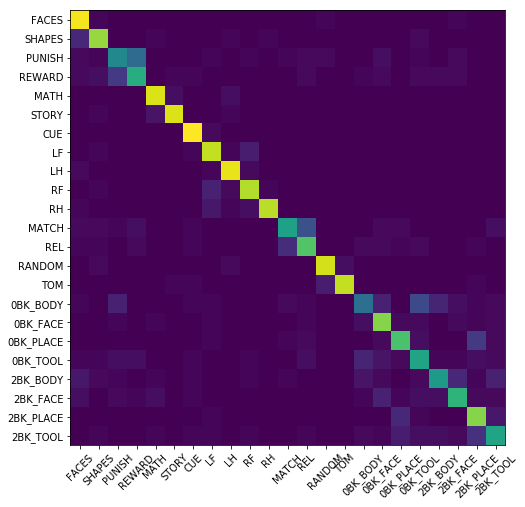

In [319]:
plot_confusion_matrix(test_conf, labels)

In [298]:
prediction['match'].groupby(level=['fold', 'task', 'contrast']).apply(np.mean)['test']

task        contrast 
EMOTION     FACES        0.962025
            SHAPES       0.822785
GAMBLING    PUNISH       0.455696
            REWARD       0.607595
LANGUAGE    MATH         0.924051
            STORY        0.924051
MOTOR       CUE          0.974684
            LF           0.886076
            LH           0.936709
            RF           0.860759
            RH           0.873418
RELATIONAL  MATCH        0.556962
            REL          0.708861
SOCIAL      RANDOM       0.911392
            TOM          0.886076
WM          0BK_BODY     0.354430
            0BK_FACE     0.797468
            0BK_PLACE    0.696203
            0BK_TOOL     0.569620
            2BK_BODY     0.531646
            2BK_FACE     0.632911
            2BK_PLACE    0.797468
            2BK_TOOL     0.569620
Name: match, dtype: float64

In [308]:
titles = ["%s: %s" % (value[0], value[1]) for value, title in labels.iteritems()]

/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)
/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


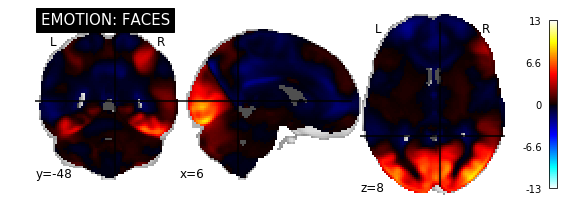

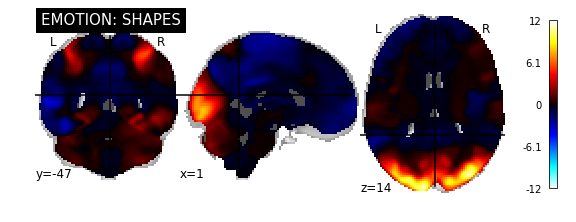

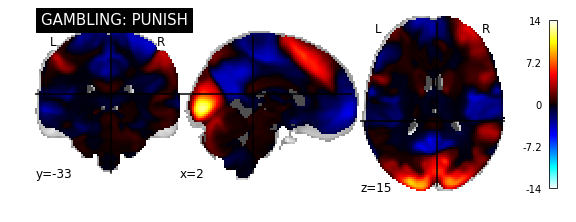

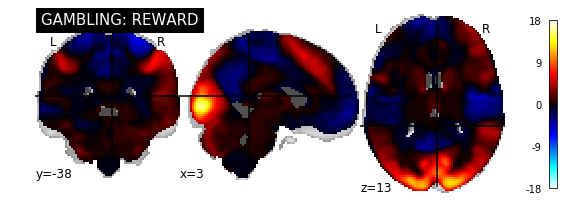

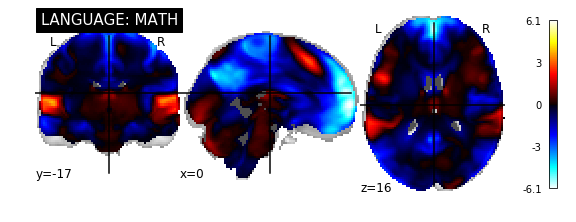

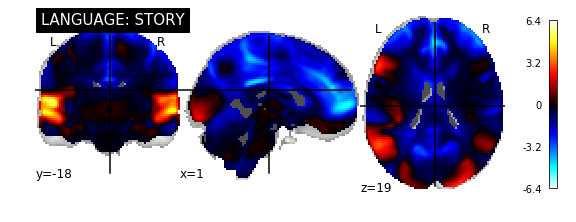

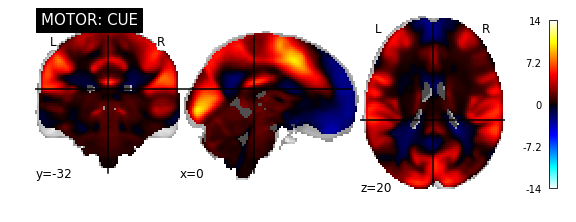

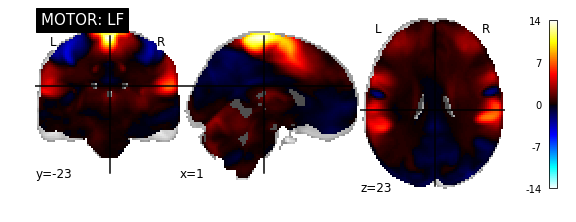

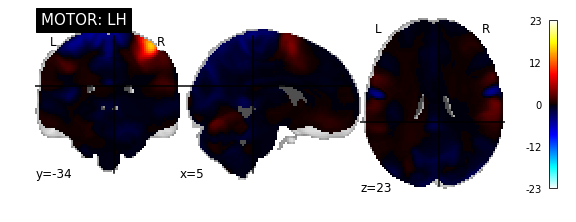

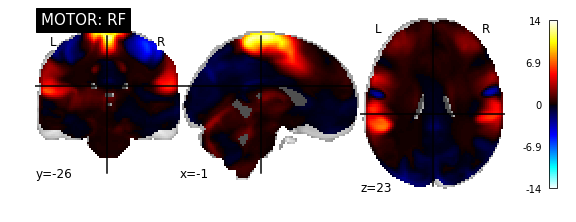

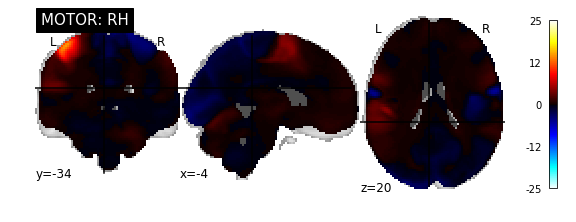

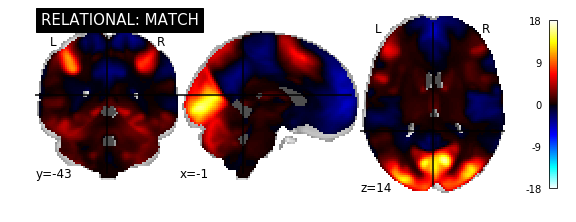

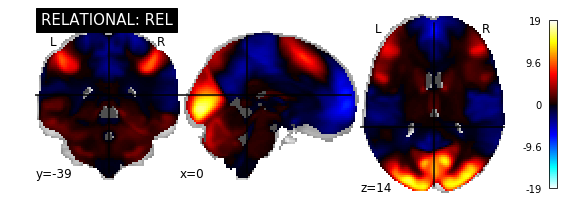

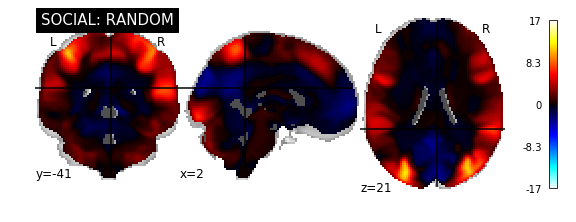

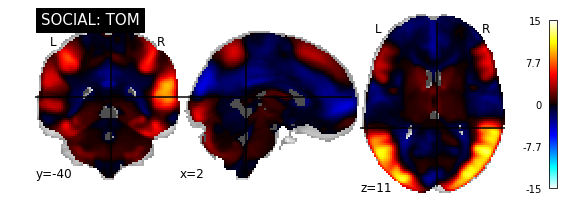

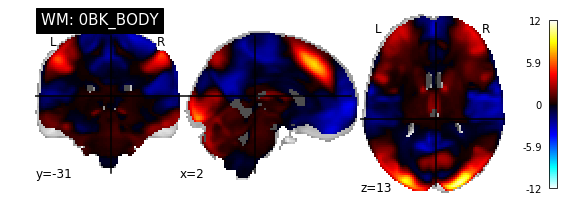

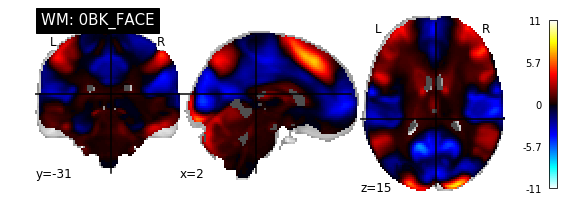

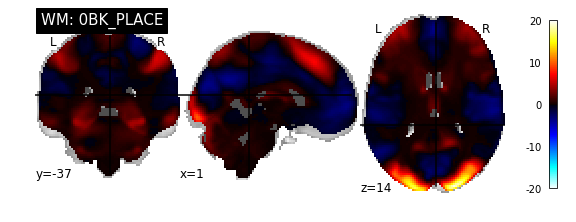

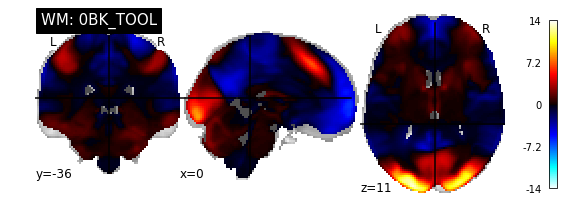

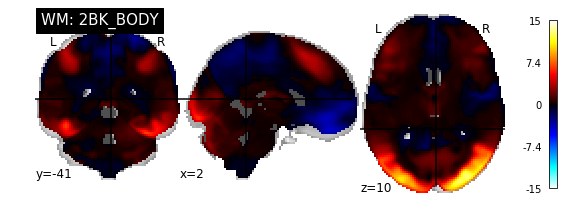

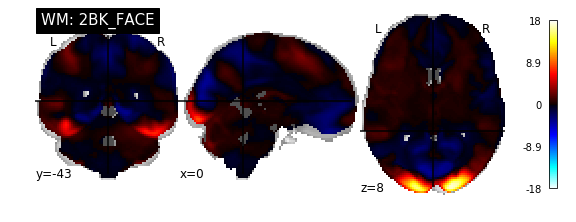

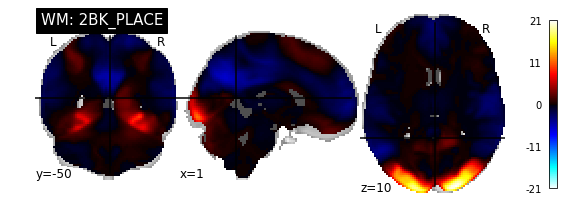

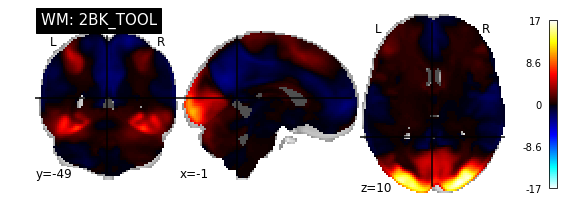

In [328]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

indices = le.transform(labels)

for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=0)

In [227]:
(np.abs(coef[:,:16]).sum())

223.63472335777993

In [228]:
(np.abs(coef[:,16:80])).sum()

931.91780012609593

In [229]:
np.abs(coef[:,80:80 + 256]).sum()

3731.9873692194706

In [230]:
np.sum(coef[:, :16] == 0) / coef[:, :16].size

0.07880434782608696

In [231]:
np.sum(coef[:, 16:80] == 0) / coef[:, 16:80].size

0.19089673913043478

In [232]:
np.sum(coef[:, 80:256] == 0) / coef[:, 80:256].size

0.35103754940711462